In [10]:
#!/usr/bin/env python3
"""
improved_lbp_glcm_pipeline.py

- ROI extraction (consistent normal/abnormal)
- per-ROI CLAHE
- LBP pooled features (adaptive bins)
- quantized GLCM features
- SelectKBest feature selection inside pipeline
- SMOTE inside CV if available, else class_weight fallback
- nested GroupKFold (inner) GridSearchCV and held-out GroupShuffleSplit
- prints and saves results to ./results/
"""
import os
import math
import pickle
import numpy as np
import pandas as pd
import cv2
from collections import Counter
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

# try to import imblearn (SMOTE & pipeline). If missing fallback will be used.
USE_SMOTE = True
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
    USE_SMOTE = False
    ImbPipeline = None
    print("[WARN] imbalanced-learn not available. Script will use class_weight='balanced' instead of SMOTE.")

# ----------------- USER CONFIG -----------------
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024               # MIAS image size reference
TARGET_SIZE = 128               # None to keep native crop size, or int to resize (128 recommended)
MIN_SIDE = 32                   # pad if ROI smaller
CLAHE_CLIP = 2.0
CLAHE_TILE = (8, 8)

# LBP params
P = 8
# You can enable multi-scale LBP; set RB list to include desired radii:
LBP_RADII = [1, 3]             # set to [3] or [1,3] for multiscale
LBP_METHOD = 'uniform'

# pooling grid for LBP
POOL_G = 3                      # 3x3 pooling (try 3,4,6). smaller reduces dims

# GLCM params (quantized)
GLCM_LEVELS = 32
GLCM_DISTANCES = [1, 3]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# CV params
OUTER_SPLITS = 5
INNER_SPLITS = 4
RANDOM_STATE = 42
HOLDOUT_TEST_SIZE = 0.2

# Grid search params
RF_PARAM_GRID = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_leaf': [2, 6],
}
SVM_PARAM_GRID = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 0.01],
}

SELECT_K = 80  # number of features to keep with SelectKBest (set based on experiments)

# ------------------------------------------------

# ---------- helper functions ----------
def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    return df

def ref_to_patient_id(ref):
    try:
        n = int(''.join(ch for ch in ref if ch.isdigit()))
        return (n - 1) // 2
    except:
        return ref

def clamp(a, lo, hi):
    return max(lo, min(hi, a))

def crop_square(img, cx, cy, r):
    H, W = img.shape
    x0 = clamp(cx - r, 0, W)
    x1 = clamp(cx + r, 0, W)
    y0 = clamp(cy - r, 0, H)
    y1 = clamp(cy + r, 0, H)
    if x1 <= x0 or y1 <= y0:
        return img.copy()
    return img[y0:y1, x0:x1]

def pad_to_min_side(img, min_side):
    h, w = img.shape
    top = bottom = left = right = 0
    if h < min_side:
        extra = min_side - h
        top = extra // 2
        bottom = extra - top
    if w < min_side:
        extra = min_side - w
        left = extra // 2
        right = extra - left
    if any([top, bottom, left, right]):
        img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType=cv2.BORDER_REFLECT)
    return img

def apply_clahe_to_roi(roi, clip=2.0, tile=(8,8)):
    if roi.dtype != np.uint8:
        if roi.max() <= 1.0:
            roi_u8 = (roi * 255).astype(np.uint8)
        else:
            roi_u8 = roi.astype(np.uint8)
    else:
        roi_u8 = roi
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    return clahe.apply(roi_u8)

def pooled_lbp_matrix(lbp_map, G=3, n_bins=None):
    H, W = lbp_map.shape
    row_edges = np.linspace(0, H, G+1, dtype=int)
    col_edges = np.linspace(0, W, G+1, dtype=int)
    rows = []
    # use dynamic n_bins from caller
    for i in range(G):
        for j in range(G):
            r0, r1 = row_edges[i], row_edges[i+1]
            c0, c1 = col_edges[j], col_edges[j+1]
            region = lbp_map[r0:r1, c0:c1]
            # ensure integer codes
            region_int = region.ravel().astype(int)
            if n_bins is None:
                n_bins_reg = int(region_int.max()) + 1 if region_int.size>0 else 1
                hist = np.bincount(region_int, minlength=n_bins_reg).astype(float)
            else:
                hist = np.bincount(region_int, minlength=n_bins).astype(float)
            if hist.sum() > 0:
                hist /= hist.sum()
            # if n_bins is provided, hist length is fixed
            if n_bins is not None and len(hist) < n_bins:
                # pad
                hist = np.pad(hist, (0, n_bins - len(hist)), mode='constant')
            rows.append(hist)
    M = np.vstack(rows)
    return M

def quantize_img_levels(img, levels=32):
    a = img.astype(np.float32)
    if a.max() > 1.1:
        a = a / 255.0
    q = np.floor(a * (levels - 1) + 0.5).astype(np.uint8)
    return q

def extract_glcm_features(patch, distances, angles, levels):
    q = quantize_img_levels(patch, levels=levels)
    glcm = graycomatrix(q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = []
    for p in props:
        mat = graycoprops(glcm, p)
        feats.append(float(np.nanmean(mat)))
        feats.append(float(np.nanvar(mat)))
    return np.array(feats, dtype=float)  # length = 2 * len(props)

# ---------- main ----------
def main():
    print("[INFO] Reading metadata...")
    df = read_metadata(META_PATH)
    refs = sorted([f for f in os.listdir(IMAGES_DIR) if f.lower().endswith('.pgm')])
    print(f"[INFO] Found {len(refs)} image files in {IMAGES_DIR}")
    radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median()) if radii.size > 0 else 48
    print("[INFO] median radius:", median_radius)

    # ROI extraction
    rois = []
    rois_raw = []   # keep a raw copy (pre-CLAHE) for comparisons
    labels = []
    groups = []
    ref_list = []

    for fname in refs:
        ref = os.path.splitext(fname)[0]
        row = df[df['REFNUM'] == ref]
        if row.empty:
            continue
        row = row.iloc[0]
        img_path = os.path.join(IMAGES_DIR, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("[WARN] cannot read", img_path); continue

        label = int(row['CANCER'])
        x, y, r = row['X'], row['Y'], row['RADIUS']

        if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(r):
            cx = int(float(x))
            cy = int(IMAGE_SIZE - float(y))  # convert bottom-left MIAS to top-left indexing
            rr = int(max(int(r), 8))
            roi = crop_square(img, cx, cy, rr)
        else:
            cx = img.shape[1] // 2
            cy = img.shape[0] // 2
            rr = median_radius
            roi = crop_square(img, cx, cy, rr)

        roi = pad_to_min_side(roi, MIN_SIDE)
        rois_raw.append(roi.copy())
        roi_clahe = apply_clahe_to_roi(roi, clip=CLAHE_CLIP, tile=CLAHE_TILE)
        if TARGET_SIZE is not None:
            if roi_clahe.shape[0] > TARGET_SIZE or roi_clahe.shape[1] > TARGET_SIZE:
                interp = cv2.INTER_AREA
            else:
                interp = cv2.INTER_LINEAR
            roi_clahe = cv2.resize(roi_clahe, (TARGET_SIZE, TARGET_SIZE), interpolation=interp)

        rois.append(roi_clahe)
        labels.append(label)
        groups.append(ref_to_patient_id(ref))
        ref_list.append(ref)

    print(f"[INFO] Extracted {len(rois)} ROIs (CLAHE applied per-ROI).")
    if len(rois) == 0:
        raise RuntimeError("No ROIs extracted - check dataset paths and metadata.")

    # Compute LBP maps for each radius and collect global max code to set fixed bins
    print("[INFO] Computing LBP maps for radii:", LBP_RADII)
    lbp_maps_per_radius = {r: [] for r in LBP_RADII}
    max_code = 0
    for roi in rois:
        # ensure float input
        img_float = roi.astype(np.float32)
        for r in LBP_RADII:
            lbp_map = local_binary_pattern(img_float, P, r, method=LBP_METHOD)
            # LBP returns floats; convert to ints safely
            lbp_int = np.round(lbp_map).astype(int)
            lbp_maps_per_radius[r].append(lbp_int)
            max_code = max(max_code, int(lbp_int.max()))

    n_lbp_bins = max_code + 1
    print(f"[INFO] Determined LBP n_bins = {n_lbp_bins}")

    # Build feature matrices
    X_lbp_parts = []  # will contain per-radius pooled LBP flattened
    X_glcm = []
    print("[INFO] Building pooled LBP histograms and GLCM features for each ROI...")
    for idx, roi in enumerate(rois):
        roi_uint8 = roi.astype(np.uint8)
        # LBP pooled for each radius, concatenate
        lbp_concat = []
        for r in LBP_RADII:
            lbp_map = lbp_maps_per_radius[r][idx]
            M = pooled_lbp_matrix(lbp_map, G=POOL_G, n_bins=n_lbp_bins)  # shape (G*G, n_bins)
            lbp_concat.append(M.ravel())
        lbp_vec = np.hstack(lbp_concat)
        X_lbp_parts.append(lbp_vec)

        # GLCM features (quantized)
        glcm_feats = extract_glcm_features(roi_uint8, distances=GLCM_DISTANCES, angles=GLCM_ANGLES, levels=GLCM_LEVELS)
        X_glcm.append(glcm_feats)

    X_lbp = np.vstack(X_lbp_parts)
    X_glcm = np.vstack(X_glcm)
    X = np.hstack([X_glcm, X_lbp])
    y = np.array(labels)
    groups_arr = np.array(groups)

    print("[INFO] Feature shapes: X_glcm", X_glcm.shape, "X_lbp", X_lbp.shape, "combined X", X.shape)
    print("Label counts:", Counter(y))
    # safety check
    if np.isnan(X).any():
        raise RuntimeError("NaN found in features!")

    # Create feature names for mapping importances
    glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    glcm_names = []
    for p in glcm_props:
        glcm_names += [f"{p}_mean", f"{p}_var"]
    lbp_names = []
    region_count = POOL_G * POOL_G
    for r in LBP_RADII:
        for region_ix in range(region_count):
            for code in range(n_lbp_bins):
                lbp_names.append(f"LBP_R{r}_r{region_ix:02d}_c{code:03d}")
    feature_names = glcm_names + lbp_names
    assert X.shape[1] == len(feature_names)

    # ---------------- train/test split (group-aware held-out) ----------------
    gss = GroupShuffleSplit(n_splits=1, test_size=HOLDOUT_TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y, groups_arr))
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    groups_tr, groups_te = groups_arr[train_idx], groups_arr[test_idx]
    print("[INFO] Train samples:", X_tr.shape[0], "Test samples:", X_te.shape[0])

    # Build pipelines: keep feature selection inside pipeline (SelectKBest)
    selector = SelectKBest(mutual_info_classif, k=min(SELECT_K, X_tr.shape[1]))

    # If SMOTE available, put inside ImbPipeline, else use sklearn Pipeline and class_weight
    if USE_SMOTE:
        rf_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])
    else:
        rf_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])

    # inner CV uses GroupKFold on training set
    def run_gridsearch(pipeline, param_grid, X_train, y_train, groups_train, name="model"):
        inner_cv = GroupKFold(n_splits=INNER_SPLITS)
        gs = GridSearchCV(pipeline, param_grid, cv=inner_cv.split(X_train, y_train, groups_train),
                          scoring='roc_auc', n_jobs=-1, verbose=1)
        gs.fit(X_train, y_train)
        print(f"[INFO] Best {name} params:", gs.best_params_)
        return gs.best_estimator_, gs

    print("[INFO] Running inner grid-search for RandomForest...")
    best_rf, rf_gs = run_gridsearch(rf_pipeline, RF_PARAM_GRID, X_tr, y_tr, groups_tr, name="RandomForest")

    print("[INFO] Running inner grid-search for SVM...")
    best_svm, svm_gs = run_gridsearch(svm_pipeline, SVM_PARAM_GRID, X_tr, y_tr, groups_tr, name="SVM")

    # Evaluate on held-out test set
    def evaluate_model(est, X_test, y_test, name="model"):
        y_pred = est.predict(X_test)
        if hasattr(est, "predict_proba"):
            try:
                y_prob = est.predict_proba(X_test)[:, 1]
            except Exception:
                y_prob = None
        else:
            y_prob = None
        print(f"\n=== Held-out evaluation: {name} ===")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred, zero_division=0))
        if y_prob is not None and len(np.unique(y_test)) > 1:
            print("AUC:", roc_auc_score(y_test, y_prob))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        return y_pred, y_prob

    ypred_rf, yprob_rf = evaluate_model(best_rf, X_te, y_te, name="RandomForest (best)")
    ypred_svm, yprob_svm = evaluate_model(best_svm, X_te, y_te, name="SVM (best)")

    # Feature importances mapping (RF)
    try:
        rf_clf = best_rf.named_steps['clf'] if USE_SMOTE else best_rf.named_steps['clf']
        importances = rf_clf.feature_importances_
        # map to names
        idxs = np.argsort(importances)[::-1][:30]
        print("\nTop 30 feature importances (index, name, importance):")
        for idx in idxs:
            print(idx, feature_names[idx], f"{importances[idx]:.4f}")
    except Exception as e:
        print("[WARN] Could not extract feature importances:", e)

    # Threshold tuning on held-out set to prioritize recall if desired (example)
    if yprob_rf is not None:
        best_thresh = 0.5
        best_recall = recall_score(y_te, (yprob_rf >= 0.5).astype(int))
        # choose threshold that maximizes recall while keeping precision >= 0.5 (example)
        for t in np.linspace(0.1, 0.9, 81):
            preds_t = (yprob_rf >= t).astype(int)
            r = recall_score(y_te, preds_t, zero_division=0)
            # for illustration choose threshold maximizing recall
            if r > best_recall:
                best_recall = r; best_thresh = t
        print(f"[INFO] RF held-out best threshold for recall (example): {best_thresh:.2f}, recall={best_recall:.3f}")
        # show confusion at best threshold
        preds_best = (yprob_rf >= best_thresh).astype(int)
        print("Confusion at chosen threshold:\n", confusion_matrix(y_te, preds_best))
        print(classification_report(y_te, preds_best))

    # Save outputs
    os.makedirs("results", exist_ok=True)
    with open(os.path.join("results", "features_X_y_groups.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr, "ref_list": ref_list, "feature_names": feature_names}, f)
    with open(os.path.join("results", "best_rf.pkl"), "wb") as f:
        pickle.dump(best_rf, f)
    with open(os.path.join("results", "best_svm.pkl"), "wb") as f:
        pickle.dump(best_svm, f)

    print("\n[INFO] Done. Results and models saved to ./results/")

if __name__ == "__main__":
    main()


[WARN] imbalanced-learn not available. Script will use class_weight='balanced' instead of SMOTE.
[INFO] Reading metadata...
[INFO] Found 324 image files in all-mias
[INFO] median radius: 43
[INFO] Extracted 324 ROIs (CLAHE applied per-ROI).
[INFO] Computing LBP maps for radii: [1, 3]


c:\python3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[INFO] Determined LBP n_bins = 10
[INFO] Building pooled LBP histograms and GLCM features for each ROI...
[INFO] Feature shapes: X_glcm (324, 12) X_lbp (324, 180) combined X (324, 192)
Label counts: Counter({np.int64(0): 207, np.int64(1): 117})
[INFO] Train samples: 258 Test samples: 66
[INFO] Running inner grid-search for RandomForest...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[INFO] Best RandomForest params: {'clf__max_depth': 12, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 300}
[INFO] Running inner grid-search for SVM...
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[INFO] Best SVM params: {'clf__C': 1, 'clf__gamma': 0.01}

=== Held-out evaluation: RandomForest (best) ===
Accuracy: 0.8333333333333334
Recall: 0.75
AUC: 0.8978174603174602
Confusion Matrix:
 [[37  5]
 [ 6 18]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        42
           1       0.78      0.75      0.77        24

    accu

Successfully loaded and processed 324 images.
Label distribution: Counter({np.int64(0): 207, np.int64(1): 117})

--- Model Evaluation on Held-Out Test Set ---
Accuracy: 0.9268
ROC AUC Score: 0.9630

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        51
           1       0.96      0.84      0.90        31

    accuracy                           0.93        82
   macro avg       0.94      0.91      0.92        82
weighted avg       0.93      0.93      0.93        82

Confusion Matrix:
 [[50  1]
 [ 5 26]]

--- Running Permutation Test (100 permutations) ---
Permutation 1/100, Score: 0.4970\rPermutation 2/100, Score: 0.4428\rPermutation 3/100, Score: 0.5666\rPermutation 4/100, Score: 0.4841\rPermutation 5/100, Score: 0.5062\rPermutation 6/100, Score: 0.4456\rPermutation 7/100, Score: 0.4689\rPermutation 8/100, Score: 0.4358\rPermutation 9/100, Score: 0.4901\rPermutation 10/100, Score: 0.5459\rPermutation 11/100

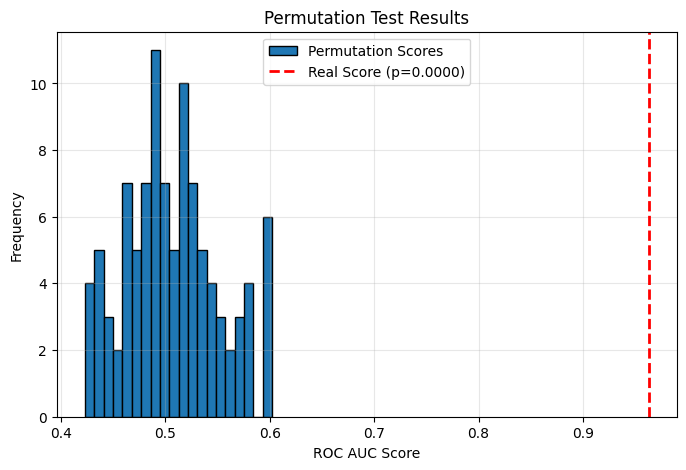

In [8]:
# Corrected_Analysis.ipynb

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from skimage import feature
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.base import clone

# --- Configuration ---
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024
TARGET_ROI_SIZE = 256
RANDOM_STATE = 42

# --- 1. Data Loading and Preprocessing ---

def load_and_prepare_data(images_dir, meta_path):
    """Loads metadata, finds images, and extracts consistent ROIs for all samples."""
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep="\\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

    # Calculate median radius from abnormal cases to use for normal cases
    radii = pd.to_numeric(df[df['CANCER'] == 1]['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median())

    all_rois = []
    all_labels = []
    all_groups = []

    for filename in sorted(os.listdir(images_dir)):
        if not filename.lower().endswith('.pgm'):
            continue
        
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]
        if record.empty:
            continue

        record = record.iloc[0]
        full_path = os.path.join(images_dir, filename)
        img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        
        label = record['CANCER']
        patient_id = int(''.join(c for c in ref_num if c.isdigit())) // 2
        
        # Consistent ROI Extraction
        x, y, r = record[['X', 'Y', 'RADIUS']]
        
        if label == 1 and all(pd.notna([x, y, r])):
            cx, cy, cr = int(x), int(IMAGE_SIZE - float(y)), int(r)
        else:
            # For normal cases, take a crop from the center
            cx, cy, cr = IMAGE_SIZE // 2, IMAGE_SIZE // 2, median_radius
            
        # Crop a square ROI and apply CLAHE
        x0, y0 = max(0, cx - cr), max(0, cy - cr)
        x1, y1 = min(IMAGE_SIZE, cx + cr), min(IMAGE_SIZE, cy + cr)
        roi = img_array[y0:y1, x0:x1]

        if roi.size == 0:
            continue
        
        # Apply CLAHE to the ROI
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        roi_enhanced = clahe.apply(roi)
        
        # Resize to a fixed size for consistency
        roi_resized = cv2.resize(roi_enhanced, (TARGET_ROI_SIZE, TARGET_ROI_SIZE), interpolation=cv2.INTER_AREA)
        
        all_rois.append(roi_resized)
        all_labels.append(label)
        all_groups.append(patient_id)
        
    print(f"Successfully loaded and processed {len(all_rois)} images.")
    print(f"Label distribution: {Counter(all_labels)}")
    return np.array(all_rois), np.array(all_labels), np.array(all_groups)

# --- 2. Feature Extraction ---

def extract_glcm_features(patch, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Computes GLCM features for a single patch."""
    glcm = graycomatrix(patch, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = {}
    for prop in props:
        mat = graycoprops(glcm, prop)
        feats[f'{prop}_mean'] = mat.mean()
        feats[f'{prop}_var'] = mat.var()
    return feats

def extract_lbp_features(patch, P=8, R=3, G=6):
    """Computes pooled LBP histogram features."""
    lbp = feature.local_binary_pattern(patch, P, R, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

def create_feature_matrix(rois, labels, groups):
    """Loops over all ROIs to build the final feature matrix."""
    records = []
    for roi, label, grp in zip(rois, labels, groups):
        # GLCM
        glcm_feats = extract_glcm_features(roi)
        # LBP
        lbp_feats_hist = extract_lbp_features(roi)
        lbp_feats = {f'lbp_{i}': val for i, val in enumerate(lbp_feats_hist)}
        
        # Combine features and metadata
        all_feats = {**glcm_feats, **lbp_feats}
        all_feats['label'] = label
        all_feats['group'] = grp
        records.append(all_feats)
        
    df = pd.DataFrame.from_records(records)
    return df

# --- 3. Model Training and Evaluation ---

# Run the pipeline
rois, labels, groups = load_and_prepare_data(IMAGES_DIR, META_PATH)
feature_df = create_feature_matrix(rois, labels, groups)

X = feature_df.drop(columns=['label', 'group']).values
y = feature_df['label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group-aware train/test split to prevent data leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X_scaled, y, groups))

X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- Model Training ---
clf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, class_weight='balanced')
clf.fit(X_train, y_train)

# --- Evaluation ---
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation on Held-Out Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 4. Permutation Test ---
print("\n--- Running Permutation Test (100 permutations) ---")
cv = GroupShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE)
score_real, _, _ = roc_auc_score(y_test, y_prob), None, None # Using held-out score as the real score

n_permutations = 100
perm_scores = []
for i in range(n_permutations):
    y_permuted = np.random.permutation(y)
    # Using a simple CV for the permutation test for speed
    perm_clf = clone(clf)
    score = cross_val_score(perm_clf, X_scaled, y_permuted, cv=cv, groups=groups, scoring='roc_auc').mean()
    perm_scores.append(score)
    print(f"Permutation {i+1}/{n_permutations}, Score: {score:.4f}", end='\\r')

p_value = (np.sum(np.array(perm_scores) >= score_real)) / n_permutations
print(f"\\nReal Model ROC AUC: {score_real:.4f}")
print(f"Permutation Scores Mean: {np.mean(perm_scores):.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result is statistically significant.")
else:
    print("Result is not statistically significant.")

# Plot permutation scores
plt.figure(figsize=(8, 5))
plt.hist(perm_scores, bins=20, label='Permutation Scores', edgecolor='k')
plt.axvline(score_real, color='red', linestyle='--', linewidth=2, label=f'Real Score (p={p_value:.4f})')
plt.title("Permutation Test Results")
plt.xlabel("ROC AUC Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ------- -------------------------------- 10.5/56.8 MB 54.7 MB/s eta 0:00:01
   --------------------- ------------------ 31.2/56.8 MB 82.5 MB/s eta 0:00:01
   ---------------------------------- ----- 49.3/56.8 MB 84.8 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 78.7 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
#
# Improved_LBP_GLCM_Pipeline.ipynb
#
# This script improves upon the robust structure of Method2 by adding
# data augmentation, a more powerful XGBoost classifier, and a more
# comprehensive hyperparameter search to maximize performance with LBP/GLCM features.
#

import os
import cv2
import numpy as np
import pandas as pd
from collections import Counter

# Scikit-learn and XGBoost imports
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from skimage.feature import graycomatrix, graycoprops

# --- Configuration ---
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024
TARGET_ROI_SIZE = 128
RANDOM_STATE = 42

# CV and Split Configuration
HOLDOUT_TEST_SIZE = 0.2
INNER_CV_SPLITS = 4 # K-fold for grid search

# --- 1. Data Loading and Preprocessing with Augmentation ---

def load_and_prepare_data(images_dir, meta_path, augment_train=True):
    """Loads metadata and extracts ROIs. Includes an option for horizontal flip augmentation."""
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep="\\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    radii = pd.to_numeric(df[df['CANCER'] == 1]['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median())

    data = [] # Store tuples of (roi, label, group, is_augmented)

    print("Loading and preprocessing images...")
    for filename in sorted(os.listdir(images_dir)):
        if not filename.lower().endswith('.pgm'):
            continue
        
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]
        if record.empty: continue

        record = record.iloc[0]
        full_path = os.path.join(images_dir, filename)
        img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        
        label = record['CANCER']
        patient_id = int(''.join(c for c in ref_num if c.isdigit())) // 2 if ref_num[3:].isdigit() else ref_num

        x, y, r = record[['X', 'Y', 'RADIUS']]
        if label == 1 and all(pd.notna([x, y, r])):
            cx, cy, cr = int(x), int(IMAGE_SIZE - float(y)), int(r)
        else:
            cx, cy, cr = IMAGE_SIZE // 2, IMAGE_SIZE // 2, median_radius
            
        x0, y0 = max(0, cx - cr), max(0, cy - cr)
        x1, y1 = min(IMAGE_SIZE, cx + cr), min(IMAGE_SIZE, cy + cr)
        roi = img_array[y0:y1, x0:x1]

        if roi.size == 0: continue
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        roi_enhanced = clahe.apply(roi)
        roi_resized = cv2.resize(roi_enhanced, (TARGET_ROI_SIZE, TARGET_ROI_SIZE), interpolation=cv2.INTER_AREA)
        
        data.append({'roi': roi_resized, 'label': label, 'group': patient_id, 'is_augmented': False})

        # *** IMPROVEMENT: DATA AUGMENTATION ***
        # Add a horizontally flipped version of the ROI
        if augment_train:
            roi_flipped = cv2.flip(roi_resized, 1)
            data.append({'roi': roi_flipped, 'label': label, 'group': patient_id, 'is_augmented': True})

    print(f"Loaded {len(data)} images (including augmented).")
    return pd.DataFrame(data)

# --- 2. Feature Extraction (LBP + GLCM) ---

# CORRECTED FUNCTION

def extract_features(roi):
    """Extracts a combined feature vector of LBP and GLCM for a single ROI."""
    # LBP Features
    P, R, G = 8, 3, 3 # Points, Radius, Grid size
    lbp = feature.local_binary_pattern(roi, P, R, method='uniform')
    
    # --- FIX ---
    # Use a fixed number of bins for uniform LBP (P + 2)
    n_bins = P + 2 
    # --- END FIX ---
    
    # Pooled histogram
    H, W = lbp.shape
    h_step, w_step = H // G, W // G
    lbp_hist = []
    for i in range(G):
        for j in range(G):
            region = lbp[i*h_step:(i+1)*h_step, j*w_step:(j+1)*w_step]
            # Use fixed n_bins and range
            hist, _ = np.histogram(region.ravel(), bins=n_bins, range=(0, n_bins))
            lbp_hist.extend(hist)
    lbp_features = np.array(lbp_hist, dtype=float)

    # GLCM Features
    glcm = graycomatrix(roi, distances=[1, 3], angles=[0, np.pi/4, np.pi/2], levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    glcm_features = []
    for prop in props:
        glcm_features.extend(graycoprops(glcm, prop).ravel())
        
    # Combine and return
    return np.concatenate([lbp_features, glcm_features])
# --- 3. Model Training and Evaluation Pipeline ---

# Step 1: Load data
full_dataset = load_and_prepare_data(IMAGES_DIR, META_PATH, augment_train=True)

# Step 2: Group-aware train/test split (BEFORE feature extraction and augmentation handling)
# We split based on original images to ensure augmented versions stay with their originals.
original_indices = full_dataset[full_dataset['is_augmented'] == False].index
gss = GroupShuffleSplit(n_splits=1, test_size=HOLDOUT_TEST_SIZE, random_state=RANDOM_STATE)
train_idx_orig, test_idx_orig = next(gss.split(original_indices, groups=full_dataset.loc[original_indices, 'group']))

# Get the full training set (originals + their augmented pairs)
train_groups = full_dataset.loc[original_indices[train_idx_orig], 'group'].unique()
train_df = full_dataset[full_dataset['group'].isin(train_groups)]

# The test set contains ONLY original, non-augmented images
test_df = full_dataset.loc[original_indices[test_idx_orig]]

print(f"Training set size: {len(train_df)} (after augmentation)")
print(f"Test set size: {len(test_df)} (original images only)")

# Step 3: Extract features for train and test sets
print("\nExtracting features for training and test sets...")
X_train = np.array([extract_features(roi) for roi in train_df['roi']])
y_train = train_df['label'].values
groups_train = train_df['group'].values

X_test = np.array([extract_features(roi) for roi in test_df['roi']])
y_test = test_df['label'].values

# Step 4: Define pipelines and hyperparameter grids
scaler = StandardScaler()
selector = SelectKBest(mutual_info_classif)

# Pipeline definitions
rf_pipeline = Pipeline([('scaler', scaler), ('select', selector), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
svm_pipeline = Pipeline([('scaler', scaler), ('select', selector), ('clf', SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced'))])
xgb_pipeline = Pipeline([('scaler', scaler), ('select', selector), ('clf', XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'))])


# *** IMPROVEMENT: Expanded Hyperparameter Grids ***
rf_params = {
    'select__k': [40, 80, 120],
    'clf__n_estimators': [100, 250, 500],
    'clf__max_depth': [5, 10, 20, None],
    'clf__min_samples_leaf': [1, 3, 5]
}

svm_params = {
    'select__k': [40, 80, 120],
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.001]
}

xgb_params = {
    'select__k': [40, 80, 120],
    'clf__n_estimators': [100, 250, 500],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2]
}

pipelines = {
    'RandomForest': (rf_pipeline, rf_params),
    'SVM': (svm_pipeline, svm_params),
    'XGBoost': (xgb_pipeline, xgb_params) # *** IMPROVEMENT: Added XGBoost ***
}

# Step 5: Run GridSearchCV for each model
print("\n--- Starting Hyperparameter Tuning ---")
best_estimators = {}
inner_cv = GroupKFold(n_splits=INNER_CV_SPLITS)

for name, (pipeline, params) in pipelines.items():
    print(f"\nTuning {name}...")
    gs = GridSearchCV(pipeline, params, cv=inner_cv.split(X_train, y_train, groups_train), scoring='roc_auc', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    print(f"Best Score (AUC) for {name}: {gs.best_score_:.4f}")
    print(f"Best Params for {name}: {gs.best_params_}")

# Step 6: Evaluate the best models on the held-out test set
print("\n--- Final Model Evaluation on Held-Out Test Set ---")
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n--- Results for Best {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Cancer"]))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Loading and preprocessing images...
Loaded 648 images (including augmented).
Training set size: 516 (after augmentation)
Test set size: 66 (original images only)

Extracting features for training and test sets...

--- Starting Hyperparameter Tuning ---

Tuning RandomForest...
Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best Score (AUC) for RandomForest: 0.9199
Best Params for RandomForest: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 500, 'select__k': 40}

Tuning SVM...
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best Score (AUC) for SVM: 0.9140
Best Params for SVM: {'clf__C': 100, 'clf__gamma': 0.001, 'select__k': 40}

Tuning XGBoost...
Fitting 4 folds for each of 81 candidates, totalling 324 fits
Best Score (AUC) for XGBoost: 0.9312
Best Params for XGBoost: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 100, 'select__k': 40}

--- Final Model Evaluation on Held-Out Test Set ---

--- Results for Best

C:\Users\aa23147\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:56:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
